In [1]:
CUTOFF = 10

In [2]:
import csv
from tqdm import tqdm

# Initialize an empty list to store the records
parsed_records = []

# Open and read the CSV file
with open('data/KDD19/anno_querysatisfaction.csv', 'r', encoding='utf-8') as csvfile:
    csvreader = csv.DictReader(csvfile)
    
    # Loop through each row in the CSV
    for row in tqdm(csvreader, desc="Processing", unit="rows"):
        # Create a dictionary for each record
        record = {
            'id': row['id'],
            'studentID': row['studentID'],
            'task_id': row['task_id'],
            'query': row['query'],
            'score': row['score']
        }
        # Append the record dictionary to the list
        parsed_records.append(record)

# Show first 5 records for verification
print(len(parsed_records))
print(parsed_records[:5])

Processing: 1548rows [00:00, 153540.87rows/s]

1548
[{'id': '5', 'studentID': '2014012759', 'task_id': '11', 'query': ' 清华游泳馆', 'score': '5'}, {'id': '6', 'studentID': '2014012759', 'task_id': '4', 'query': ' 行李托运 国际航班', 'score': '3'}, {'id': '7', 'studentID': '2014012759', 'task_id': '4', 'query': ' 行李托运 国际航班 美国', 'score': '2'}, {'id': '8', 'studentID': '2014012759', 'task_id': '4', 'query': ' 行李托运 国际航班', 'score': '3'}, {'id': '9', 'studentID': '2014012759', 'task_id': '1', 'query': ' 破冰游戏 十人', 'score': '5'}]


In [3]:
# Initialize an empty dictionary to store the inverted index
inverted_index = {}

# Loop through each parsed record to populate the inverted index
for record in tqdm(parsed_records, desc="Processing", unit="records"):
    query = record['query']
    task_id = record['task_id']
    
    # Check if the query is already in the inverted index
    if query in inverted_index:
        # If the task_id is not already in the list for this query, append it
        if task_id not in inverted_index[query]:
            inverted_index[query].append(task_id)
    else:
        # If the query is not in the inverted index, add it with the task_id as the first element in the list
        inverted_index[query] = [task_id]

# For clarity, ensure each query only maps to unique task_ids
for query, task_ids in inverted_index.items():
    inverted_index[query] = list(set(task_ids))
    if len(inverted_index[query]) > 1:
        print(f"Multiple tasks query found: {query}. Tasks: {', '.join(inverted_index[query])}")

Processing: 100%|█████████████████| 1548/1548 [00:00<00:00, 1318599.23records/s]

Multiple tasks query found:  北京周边 旅游. Tasks: 2, 3
Multiple tasks query found: 清华大学. Tasks: 11, 3
Multiple tasks query found: 京东. Tasks: 10, 3
Multiple tasks query found: 淘宝. Tasks: 8, 3


In [4]:
# Unique queries in user records
query_codebook = {query: str(i+1) for i, query in enumerate(inverted_index.keys())}

# sample
print(len(query_codebook))
print(dict(list(query_codebook.items())[:5]))

1092
{' 清华游泳馆': '1', ' 行李托运 国际航班': '2', ' 行李托运 国际航班 美国': '3', ' 破冰游戏 十人': '4', ' 戒烟': '5'}


In [5]:
doc_topic_map = {}
doc_text_map = {}

import csv
from tqdm import tqdm
from bs4 import BeautifulSoup
import re

pattern_date_flexible = r'\xa0-\xa0\d{4}-\d{1,2}-\d{1,2}'
pattern_html_tags = r'<.*?>'
unwanted_text = '翻译此页 \xa0-\xa0快照\xa0-\xa0预览'

def remove_hyperlinks(text):
    text1 = re.sub(r'www\.[^\s]+|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text2 = re.sub(pattern_date_flexible, '', text1)  # Remove date pattern
    text3 = re.sub(pattern_html_tags, '', text2)  # Remove HTML tags
    return text3

# Define a function to extract text from the HTML content
def extract_text_from_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Remove content within <div class="r-sech ext_query">
    for div in soup.find_all("div", class_="r-sech ext_query"):
        div.decompose()
    
    # Extract text from the parsed HTML
    extracted_text = soup.get_text()
    
    # Remove unwanted trailing text
    if unwanted_text in extracted_text:
        extracted_text = extracted_text.replace(unwanted_text, "")
    
    final_text = remove_hyperlinks(extracted_text)
        
    return final_text.strip()

exception_query = []

with open('data/KDD19/anno_searchresult.csv', 'r', encoding='utf-8') as csvfile:
    csvreader = csv.DictReader(csvfile)
    
    for row in tqdm(csvreader, desc="Processing", unit="rows"):
        query = row['query']
        if query not in query_codebook:
            if query not in exception_query:
                exception_query.append(query)
            continue
        rank = row['rank']
        docno = query_codebook[query] + '_' + rank
        
        # Extract text from the HTML content
        content_text = extract_text_from_html(row["content"])
        doc_text_map[docno] = content_text
        # Check if query exists in invert_index, if not assign it to a dummy topic
        topic = inverted_index.get(query, ['unknown_topic'])
        
        doc_topic_map[docno] = topic

Processing: 18389rows [00:23, 791.32rows/s]


In [6]:
print(len(exception_query))

100


In [7]:
# sample
print(len(doc_topic_map))
print(dict(list(doc_topic_map.items())[:5]))
print(dict(list(doc_text_map.items())[:10]))

16870
{'728_0': ['7'], '728_1': ['7'], '728_2': ['7'], '728_3': ['7'], '728_4': ['7']}
{'728_0': '看看戒烟的十大好处   首先要下定决心知道戒烟的好处有哪些，那么接下来就和天天营养的编编一起先来看看戒烟的好处吧！ 1，延缓皮肤衰老 停止吸烟能延缓面部衰老，延迟皱纹出现。不吸烟者的皮肤...', '728_1': '戒烟的好处 - 三九养生堂   今天小编就给大家介绍一下如何戒烟、戒烟的好处以及戒烟后的症状，刚兴趣的小伙伴 医院戒烟门诊已64天无人就诊沈阳男性吸烟率44.7%，戒烟门诊患者却不多2015年12月28日...  三九养生堂 -', '728_2': '戒烟的好处有哪些_亲子百科_太平洋亲子网   （二）戒烟后的远期好处 1、患癌的危险性减少 戒烟5-10年后，其肺癌死亡率比不吸烟者略为高一点，戒烟10-15后，得肺癌的机会便可降低到与不吸烟一样。据日本调查，吸烟总...  baike.pcbaby.com.cn...', '728_3': '戒烟的好处非常多 - 好大夫在线   2014年3月7日 - 戒烟的好处非常多： 1）戒烟一天， 戒烟给心脏、血压和血液系统带来的益处便会显现出来 。 2）戒烟1年，冠心病的超额危险性比继续吸烟者下降一半 。 3）戒...  好大夫在线 -', '728_4': '看看戒烟后不同时间段的好处   1.戒烟后20分钟心率开始恢复正常 戒烟的健康益处立即就会显现出来。距离你吸完最后一支香烟20分钟，你的心率就渐渐开始向正常水平恢复。 2.戒烟后两小时外周循环得到改善 ...', '728_5': '男人长期戒烟的几种好处   戒烟的好处——血液循环改善，男性阴茎部的血流量也会增加，最直接的结果是性能力会增强，并且睾丸能制造出品质更佳的精子，利于优生。 戒烟的好处——如果不幸受了伤，...  烟草在线 -', '728_6': '戒烟的好处有哪些_戒烟对身体的好处详解！   因此你在体验戒烟的好处时，他人也会感受到。如果你吸了烟，那么可以采取到一定的方法来进行戒烟，有些人也许会认为戒烟根本就没有什么治疗的方法。 免责声明：美乐乐家居...  美乐乐 -', '728_7': '戒烟的好处-求医网    戒烟的好处 （1）做家人

In [8]:
# topic-doc
topic_doc_map = {}
for docno, topics in doc_topic_map.items():
    for topic in topics:
        if topic not in topic_doc_map:
            topic_doc_map[topic] = []
        topic_doc_map[topic].append(docno)

In [9]:
# sample
print(len(topic_doc_map))
#print(dict(list(topic_doc_map.items())[:1]))

9


# Utility Functions to Compute Sentence Similarity

In [10]:
from Levenshtein import distance, ratio
import jieba
from collections import Counter
from math import sqrt

SW_PATH = 'utils/stop_words.txt'
SW_LIST = [k.strip() for k in open(SW_PATH, encoding='utf8').readlines() if k.strip() != '']

# Get Stopword List
def get_tl_no_sw(input_sentence):
    token_list = jieba.cut(input_sentence)
    return list(filter(lambda x: not(x == ' ' or (len(x) == 1 and x in SW_LIST)), token_list))


In [11]:
# Solution 1
# Levenshtein normalized similarity

def get_lev_sim(list1, list2):
    return ratio(''.join(sl_no_sw_1), ''.join(sl_no_sw_2))

# Solution 2
# Cosine Similarity

def get_cos_sim(list1, list2):
    # Step 1: Create a vocabulary
    vocab = set(list1) | set(list2)
    
    # Step 2: Create word frequency vectors
    vec1 = Counter(list1)
    vec2 = Counter(list2)
    
    # Step 3: Calculate cosine similarity
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = sqrt(sum1) * sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


In [12]:
# Define a placeholder get_sim function for demonstration purpose
def get_sim(tl_1, tl_2):
    return get_cos_sim(tl_1, tl_2)

In [13]:
import json
from tqdm import tqdm

# VERY time consuming
def get_similarity_pair():
    for k, v in tqdm(doc_text_map.items(), desc="Processing", unit="docs"):
        doc_text_map[k] = get_tl_no_sw(v)
    similarity_scores = {}
    # For each topic, compare each document with every other document in the same topic
    for topic, documents in topic_doc_map.items():
        print("Currently processing: " + topic)
        for doc_id1 in tqdm(documents, desc="Processing topics"):
            for doc_id2 in documents:
                # Ensure doc_id1 is smaller than doc_id2
                if doc_id1 >= doc_id2:
                    continue
                # Calculate similarity
                similarity = get_sim(doc_text_map[doc_id1], doc_text_map[doc_id2])
                # Store in the dictionary
                if doc_id1 not in similarity_scores:
                    similarity_scores[doc_id1] = {}
                similarity_scores[doc_id1][doc_id2] =  round(similarity, 3)

    # Save the similarity scores to a JSON file
    OUTPUT_FILE = "output/similarity_scores_kdd.json"
    with open(OUTPUT_FILE, 'w') as f:
        json.dump(similarity_scores, f)

In [14]:
#get_similarity_pair()
# or read json file directly
#with open('output/similarity_scores_kdd.json', 'r', encoding='utf-8') as file:
#    similarity_scores = json.load(file)

In [15]:
import os
if not os.path.exists('output/similarity_scores_kdd.json'):
    get_similarity_pair()
    
# Read JSON file directly
with open('output/similarity_scores_kdd.json', 'r', encoding='utf-8') as file:
    similarity_scores = json.load(file)

In [16]:
similarity_pair_list = [(docno1, docno2, score) 
               for docno1, inner_dict in similarity_scores.items() 
               for docno2, score in inner_dict.items()]

print(similarity_pair_list[:5])

[('728_0', '728_1', 0.416), ('728_0', '728_2', 0.418), ('728_0', '728_3', 0.375), ('728_0', '728_4', 0.332), ('728_0', '728_5', 0.39)]


In [17]:
import numpy as np

# Extract the similarity scores
similarity_list = [x[2] for x in similarity_pair_list]

# Function to calculate the xth percentile
def calculate_percentile(scores, x):
    return np.percentile(scores, x)

# Calculate percentiles for 10, 20, 25, 50, 75, 90
percentiles = [80, 90, 95, 99, 99.5, 99.9]
percentile_values = {x: calculate_percentile(similarity_list, x) for x in percentiles}

percentile_values

{80: 0.305, 90: 0.378, 95: 0.445, 99: 0.594, 99.5: 0.676, 99.9: 0.976}

# Utility Functions to Get Document Usefulness & Relevance

## Relevance

In [18]:
# Here is the complete code to read the txt file and process it

# Initialize the result dictionary
doc_task_relevance_map = {}

# Read the file and parse it line by line
with open('data/KDD19/all_relevance_annotation.txt', 'r', encoding='utf-8') as file:
    # Skip the header line (column names)
    file.readline()
    
    # Read each line from the file
    for line in file:
        # Split each line by tab to get individual elements
        task, query, url, rank, query_relevance, task_relevance = line.split('\t')
        
        # Get the query_id from query_codebook
        query_id = query_codebook.get(query, None)
        
        # Skip if query not in query_codebook
        if query_id is None:
            continue
        
        # Create docno
        docno = query_id + '_' + rank.strip()
        
        # Add to the result dictionary
        doc_task_relevance_map[docno] = int(task_relevance.strip())

In [55]:
print(dict(list(doc_task_relevance_map.items())[:5]))
# Values
values = np.array(list(doc_task_relevance_map.values()))

# Calculate mean and standard deviation
mean_value = np.mean(values)
std_dev_value = np.std(values)

mean_value, std_dev_value

{'345_0': 1, '675_2': 3, '277_1': 3, '111_9': 2, '260_9': 2}


(1.6487360376249265, 1.0475524460698085)

## Usefulness

In [20]:
import csv

# Initialize the result dictionary
record_score_map = {}

# Read the CSV file
with open('data/KDD19/anno_annotation.csv', 'r', encoding='utf-8') as csvfile:
    csvreader = csv.DictReader(csvfile)
    
    # Read each row in the csv
    for row in csvreader:
        # Get necessary fields
        studentID = row['studentID']
        task_id = row['task_id']
        query = row['query']
        result_id = row['result_id'].replace('rb_', '')
        score = row['score']
        
        # Get query_id from query_codebook
        query_id = query_codebook.get(query, None)
        
        # Skip if query not in query_codebook
        if query_id is None:
            continue
        
        # Create record_id
        record_id = f"{studentID}_{task_id}_{query_id}_{result_id}"
        
        # Add to result dictionary
        record_score_map[record_id] = int(score)

# Show a portion of the result
dict(list(record_score_map.items())[:5])

{'2014012759_11_1_0': 4,
 '2014012759_4_2_2': 3,
 '2014012759_4_3_1': 2,
 '2014012759_4_3_7': 1,
 '2014012759_1_4_0': 3}

In [21]:
# Initialize result list and temporary dictionary to keep track of groups
result_list_grouped_queries = []
temp_dict = {}

# Group parsed_records by id and studentID, then append queries into a list
for record in parsed_records:
    key = (record['task_id'], record['studentID'])
    if key not in temp_dict:
        temp_dict[key] = {'task_id': record['task_id'], 'student_id': record['studentID'], 'query': []}
    temp_dict[key]['query'].append(record['query'])

# Convert the grouped records into the desired list format
for key, value in temp_dict.items():
    result_list_grouped_queries.append(value)

result_list_grouped_queries

print(len(result_list_grouped_queries))
print(result_list_grouped_queries)

450
[{'task_id': '11', 'student_id': '2014012759', 'query': [' 清华游泳馆']}, {'task_id': '4', 'student_id': '2014012759', 'query': [' 行李托运 国际航班', ' 行李托运 国际航班 美国', ' 行李托运 国际航班']}, {'task_id': '1', 'student_id': '2014012759', 'query': [' 破冰游戏 十人']}, {'task_id': '7', 'student_id': '2014012759', 'query': [' 戒烟', ' 戒烟 好处', ' 戒烟 副作用', ' 戒烟 方法']}, {'task_id': '10', 'student_id': '2014012759', 'query': [' 港版 iPhone', '香港 iPhone']}, {'task_id': '8', 'student_id': '2014012759', 'query': [' 谷歌眼镜', ' 谷歌眼镜 售价', ' 谷歌眼镜 功能']}, {'task_id': '3', 'student_id': '2014012759', 'query': [' 北京周边 旅游']}, {'task_id': '2', 'student_id': '2014012759', 'query': [' 死飞 自行车', ' 死飞 自行车 购买']}, {'task_id': '12', 'student_id': '2014012759', 'query': [' 辽宁号 航母']}, {'task_id': '10', 'student_id': '2017213705', 'query': [' iphone6售价', 'iphone6售价', 'iphone6京东', 'iphone6在香港卖多少钱', '如何在香港购买iphone', '港版iphone是否支持国内运营商网络', '港版iphone6是否支持国内运营商网络']}, {'task_id': '7', 'student_id': '2016310023', 'query': [' 戒烟的好处', '戒烟的副作用', '戒烟的方法', '戒

In [22]:
import numpy as np

# Extract the similarity scores
similarity_list = [x[2] for x in similarity_pair_list]

# Function to calculate the xth percentile
def calculate_percentile(scores, x):
    return np.percentile(scores, x)

# Calculate percentiles for 10, 20, 25, 50, 75, 90
percentiles = [80, 90, 95, 99, 99.5, 99.9]
percentile_values = {x: calculate_percentile(similarity_list, x) for x in percentiles}

percentile_values

{80: 0.305, 90: 0.378, 95: 0.445, 99: 0.594, 99.5: 0.676, 99.9: 0.976}

# Find Potential Decoy Pairs

In [23]:
SIM_THRESHOLD_DECOY_MIN = calculate_percentile(similarity_list, 99)   # 假设的相似度阈值
SIM_THRESHOLD_DECOY_MAX = 0.95
# Initialize an empty list to store the decoy pairs
decoy_pair = []

# Loop through each record in result_list_grouped_queries
for record in result_list_grouped_queries:
    student_id = record['student_id']
    task_id = record['task_id']
    queries = record['query']
    
    for query_order, query in enumerate(queries):
        query_id = query_codebook.get(query, None)  # Retrieve query_id from query_codebook
        if query_id is None:
            continue  # Skip if query_id is not found
        
        # Generate docnos for the top CUTOFF ranks
        docnos = [f"{query_id}_{rank}" for rank in range(CUTOFF)]
        
        # Loop through each pair of docnos to calculate similarity and relevance
        for i, docno1 in enumerate(docnos):
            for j, docno2 in enumerate(docnos):
                if i >= j:
                    continue  # Skip duplicate pairs
                
                # Retrieve similarity score
                similarity = similarity_scores.get(docno1, {}).get(docno2, 0)  # Handle key not existing
                if similarity == 0:
                    similarity = similarity_scores.get(docno2, {}).get(docno1, 0)  # Reverse key order
                
                # Retrieve relevance score
                rel_doc1 = doc_task_relevance_map.get(docno1, 0)  # Handle key not existing
                rel_doc2 = doc_task_relevance_map.get(docno2, 0)  # Handle key not existing
                
                # Check conditions and append to decoy_pair list
                if SIM_THRESHOLD_DECOY_MIN <= similarity <= SIM_THRESHOLD_DECOY_MAX and abs(i-j) <= 5:
                    if rel_doc1 - rel_doc2 >= 2:
                        decoy_pair.append({
                            'student_id': student_id,
                            'task_id': task_id,
                            'session_num': student_id + '_' + task_id,
                            'interaction_num': str(query_order),
                            'docno_target': docno1,
                            'rank_target': i,
                            'docno_decoy': docno2,
                            'rank_decoy': j
                        })
                    elif rel_doc2 - rel_doc1 >= 2:
                        decoy_pair.append({
                            'student_id': student_id,
                            'task_id': task_id,
                            'session_num': student_id + '_' + task_id,
                            'interaction_num': str(query_order),
                            'docno_target': docno2,
                            'rank_target': j,
                            'docno_decoy': docno1,
                            'rank_decoy': i
                        })

# Show the first few decoy pairs as a sample
print(len(decoy_pair))
print(decoy_pair[:5])

922
[{'student_id': '2014012759', 'task_id': '7', 'session_num': '2014012759_7', 'interaction_num': '0', 'docno_target': '5_1', 'rank_target': 1, 'docno_decoy': '5_0', 'rank_decoy': 0}, {'student_id': '2014012759', 'task_id': '7', 'session_num': '2014012759_7', 'interaction_num': '0', 'docno_target': '5_2', 'rank_target': 2, 'docno_decoy': '5_0', 'rank_decoy': 0}, {'student_id': '2014012759', 'task_id': '7', 'session_num': '2014012759_7', 'interaction_num': '0', 'docno_target': '5_3', 'rank_target': 3, 'docno_decoy': '5_0', 'rank_decoy': 0}, {'student_id': '2014012759', 'task_id': '7', 'session_num': '2014012759_7', 'interaction_num': '0', 'docno_target': '5_4', 'rank_target': 4, 'docno_decoy': '5_0', 'rank_decoy': 0}, {'student_id': '2014012759', 'task_id': '7', 'session_num': '2014012759_7', 'interaction_num': '0', 'docno_target': '5_1', 'rank_target': 1, 'docno_decoy': '5_5', 'rank_decoy': 5}]


In [24]:
decoy_index = [item['docno_target'] for item in decoy_pair]
print("Decoy Pairs Count: %d"%len(decoy_index))
print("Count of Documents that have at least one decoy: %d"%len(set(decoy_index)))
#print(decoy_index[:5])

Decoy Pairs Count: 922
Count of Documents that have at least one decoy: 376


# Find Control Documents

In [25]:
relevance_data = doc_task_relevance_map
# Assuming a threshold for the sake of demonstration
SIM_THRESHOLD_CONTROL = calculate_percentile(similarity_list, 99.5)  
print(SIM_THRESHOLD_CONTROL)
target_doc_list = []
control_doc_list = []

# Processing the data as per given conditions
for docno1, docno2, similarity_score in similarity_pair_list:
    if similarity_score > SIM_THRESHOLD_CONTROL:
        # 检查条件
        rel_doc1 = relevance_data[docno1] if docno1 in relevance_data else 0
        rel_doc2 = relevance_data[docno2] if docno2 in relevance_data else 0
        if abs(rel_doc1 - rel_doc2 <= 0):
            if (docno1 in decoy_index and docno2 not in decoy_index):
                target_doc_list.append(docno1)
                control_doc_list.append(docno2)
            elif (docno2 in decoy_index and docno1 not in decoy_index):
                target_doc_list.append(docno2)
                control_doc_list.append(docno1)

target_doc_set = set(target_doc_list)
print("Count of Target Documents that have at least one Control Document: %d"% len(target_doc_set))
control_doc_set = set(control_doc_list)
print("Count of Control Documents: %d" % len(control_doc_set))

0.676
Count of Target Documents that have at least one Control Document: 336
Count of Control Documents: 1706


In [26]:
list(control_doc_set)[:5]

['481_11', '113_0', '188_1', '126_18', '417_20']

In [27]:
decoy_target_record = []
decoy_decoy_record = []
for item in decoy_pair:
    if item['docno_target'] in target_doc_set:
        target_id = item['session_num'] + '_' + item['docno_target']
        decoy_id =  item['session_num'] + '_' + item['docno_decoy']
        decoy_target_record.append(target_id)
        decoy_decoy_record.append(decoy_id)
    
decoy_target_record = set(decoy_target_record)
decoy_decoy_record = set(decoy_decoy_record)

print("Records of decoy target documents, by impression : %d"%len(decoy_target_record))

Records of decoy target documents, by impression : 642


# Compare User Feedback

## target documents

### click

In [28]:
FILE_PATH_LOG = 'data/KDD19/anno_log.csv'
# Initialize list to store target_doc_interaction
target_doc_interaction = []

# Initialize variables to keep track of current impression
current_student_id = None
current_task_id = None
current_query = None
impression_docs = {}
click_durations = {}

# Function to handle exceptions and errors
def handle_exception(e, line_number):
    print(f"Exception encountered: {e} at line {line_number}")

# Get the total number of lines in the file for tqdm progress bar
total_lines = sum(1 for line in open(FILE_PATH_LOG, 'r', encoding='utf-8')) - 1  # Exclude header

# Function to parse content for time
def parse_time(content):
    time_entry = [entry.split('=')[1] for entry in content.split('\t') if entry.startswith('TIME')]
    return int(time_entry[0]) if time_entry else -1
       
# Read the file and process as per new requirements
try:
    with open(FILE_PATH_LOG, 'r', encoding='utf-8') as csvfile:
        csvreader = csv.reader(csvfile)
        header = next(csvreader)  # Skip the header

        for row in tqdm(csvreader, total=total_lines, desc="Processing"):
            try:
                _, _, student_id, task_id, action, query, content = row

                # Skip rows with empty queries or queries not in query_codebook
                if query.strip() == '' or query not in query_codebook:
                    continue

                # Check for new impression
                if current_student_id != student_id or current_task_id != task_id or current_query != query:
                    # Process click docs for last impression if current_query is initialized
                    if current_query:
                        for rank in range(10):
                            docno = f"{query_codebook[current_query]}_{rank}"
                            doc_id = f"{current_student_id}_{current_task_id}_{docno}"
                            if doc_id in decoy_target_record and docno not in click_durations:
                                target_doc_interaction.append({
                                    'docno': docno,
                                    'rank': int(docno.split("_")[1]),
                                    'click': False,
                                    'last_time': 0,
                                    'usefulness': record_score_map.get(doc_id, 0),
                                    'relevance':doc_task_relevance_map.get(docno, 0),
                                    'student_id':student_id,
                                    'task_id': task_id,
                                    'query_id': query_codebook[current_query]
                                })
                            elif doc_id in decoy_target_record and docno in click_durations:
                                target_doc_interaction.append({
                                    'docno': docno,
                                    'rank': int(docno.split("_")[1]),
                                    'click': True,
                                    'last_time': click_durations[docno],
                                    'usefulness': record_score_map.get(doc_id, 0),
                                    'relevance':doc_task_relevance_map.get(docno, 0),
                                    'student_id':student_id,
                                    'task_id': task_id,
                                    'query_id': query_codebook[current_query]
                                })

                    # Reset current impression details
                    current_student_id = student_id
                    current_task_id = task_id
                    current_query = query
                    impression_docs = {}
                    click_durations = {}

                # Process CLICK actions
                if action == 'CLICK':
                    rank = int(content.split('rank=')[1].split('\t')[0])
                    docno = f"{query_codebook[query]}_{rank}"
                    doc_id = f"{student_id}_{task_id}_{docno}"

                    if doc_id in decoy_target_record:
                        # Initialize click time duration
                        click_time = 0

                        # Loop through the next rows to find a JUMP_IN action after a JUMP_OUT action
                        jump_out_found = False
                        while True:
                            next_row = next(csvreader, None)
                            if next_row is None:
                                break

                            next_action = next_row[4]
                            next_student_id = next_row[2]
                            next_task_id = next_row[3]

                            if next_student_id != student_id or next_task_id != task_id:
                                csvreader.line_num -= 1  # Go back one row if next row is not part of current impression
                                break

                            if next_action == 'JUMP_OUT':
                                jump_out_found = True
                            elif jump_out_found and next_action == 'JUMP_IN':
                                click_time = (parse_time(next_row[6]) - parse_time(content))/1000
                                break

                        # Update click duration
                        click_durations[docno] = click_durations.get(docno, 0) + click_time

            except Exception as e:
                handle_exception(e, csvreader.line_num)
except Exception as e:
    handle_exception(e, "Reading File")
    
# Display the first few rows of the target_doc_interaction for review
print(len(target_doc_interaction))
target_doc_interaction[:5]

Processing:  64%|████████████▏      | 191674/299731 [00:00<00:00, 230344.17it/s]

Exception encountered: readonly attribute at line 123228


Processing:  87%|████████████████▍  | 259819/299731 [00:01<00:00, 217854.98it/s]

Exception encountered: readonly attribute at line 220245


Processing: 100%|██████████████████▉| 299226/299731 [00:01<00:00, 223560.24it/s]

805


[{'docno': '11_0',
  'rank': 0,
  'click': True,
  'last_time': 48.537,
  'usefulness': 1,
  'relevance': 3,
  'student_id': '2014012759',
  'task_id': '8',
  'query_id': '11'},
 {'docno': '11_3',
  'rank': 3,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 3,
  'student_id': '2014012759',
  'task_id': '8',
  'query_id': '11'},
 {'docno': '11_4',
  'rank': 4,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 3,
  'student_id': '2014012759',
  'task_id': '8',
  'query_id': '11'},
 {'docno': '14_4',
  'rank': 4,
  'click': True,
  'last_time': 51.6,
  'usefulness': 4,
  'relevance': 2,
  'student_id': '2014012759',
  'task_id': '2',
  'query_id': '14'},
 {'docno': '16_1',
  'rank': 1,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 2,
  'student_id': '2014012759',
  'task_id': '12',
  'query_id': '16'}]

### hover

In [29]:
# Initialize list to store target_doc_interaction_hover for the new task
target_doc_interaction_hover = []

# Initialize variables to keep track of current impression and hover duration
current_student_id = None
current_task_id = None
current_query = None
impression_docs = {}
hover_durations = {}

# Read the file and process as per new requirements
try:
    with open(FILE_PATH_LOG, 'r', encoding='utf-8') as csvfile:
        csvreader = csv.reader(csvfile)
        header = next(csvreader)  # Skip the header

        for row in tqdm(csvreader, total=total_lines, desc="Processing"):
            try:
                _, _, student_id, task_id, action, query, content = row

                # Skip rows with empty queries or queries not in query_codebook
                if query.strip() == '' or query not in query_codebook:
                    continue

                # Check for new impression
                if current_student_id != student_id or current_task_id != task_id or current_query != query:
                    # Process hover docs for last impression if current_query is initialized
                    if current_query:
                        for rank in range(10):
                            docno = f"{query_codebook[current_query]}_{rank}"
                            doc_id = f"{current_student_id}_{current_task_id}_{docno}"
                            if doc_id in decoy_target_record and docno not in hover_durations:
                                target_doc_interaction_hover.append({
                                    'docno': docno,
                                    'rank': int(docno.split("_")[1]),
                                    'hover': False,
                                    'last_time': 0,
                                    'usefulness': record_score_map.get(doc_id, 0)
                                })
                            elif doc_id in decoy_target_record and docno in hover_durations:
                                target_doc_interaction_hover.append({
                                    'docno': docno,
                                    'rank': int(docno.split("_")[1]),
                                    'hover': True,
                                    'last_time': hover_durations[docno],
                                    'usefulness': record_score_map.get(doc_id, 0)
                                })

                    # Reset current impression details
                    current_student_id = student_id
                    current_task_id = task_id
                    current_query = query
                    impression_docs = {}
                    hover_durations = {}

                # Process HOVER actions
                if action == 'HOVER':
                    rank = int(content.split('rank=')[1].split('\t')[0])
                    docno = f"{query_codebook[query]}_{rank}"
                    doc_id = f"{student_id}_{task_id}_{docno}"

                    if doc_id in decoy_target_record:
                        # Find hover time duration from next row
                        next_row = next(csvreader, None)
                        if next_row:
                            next_student_id = next_row[2]
                            next_task_id = next_row[3]
                            hover_time = 0
                            if next_student_id == student_id and next_task_id == task_id:
                                hover_time = (parse_time(next_row[6]) - parse_time(content))/1000
                            else:
                                csvreader.line_num -= 1  # Go back one row if next row is not part of current impression

                        # Update hover duration
                        hover_durations[docno] = hover_durations.get(docno, 0) + hover_time

            except Exception as e:
                handle_exception(e, csvreader.line_num)
except Exception as e:
    handle_exception(e, "Reading File")

# Display the first few rows of the target_doc_interaction_hover for review
print(len(target_doc_interaction_hover))
target_doc_interaction_hover[:5]

Processing: 100%|██████████████████▉| 298308/299731 [00:01<00:00, 228796.78it/s]

Exception encountered: readonly attribute at line 251804
805


[{'docno': '11_0',
  'rank': 0,
  'hover': True,
  'last_time': 48.179,
  'usefulness': 1},
 {'docno': '11_3', 'rank': 3, 'hover': False, 'last_time': 0, 'usefulness': 0},
 {'docno': '11_4', 'rank': 4, 'hover': False, 'last_time': 0, 'usefulness': 0},
 {'docno': '14_4',
  'rank': 4,
  'hover': True,
  'last_time': 51.78,
  'usefulness': 4},
 {'docno': '16_1',
  'rank': 1,
  'hover': True,
  'last_time': 0.05,
  'usefulness': 0}]

### merge

In [30]:
# Merge 'hover' and 'last_time' attributes into target_doc_interaction
for i in range(len(target_doc_interaction)):
    target_doc_interaction[i]['hover'] = target_doc_interaction_hover[i]['hover']
    target_doc_interaction[i]['hover_last_time'] = target_doc_interaction_hover[i]['last_time']

target_doc_interaction[:5]

[{'docno': '11_0',
  'rank': 0,
  'click': True,
  'last_time': 48.537,
  'usefulness': 1,
  'relevance': 3,
  'student_id': '2014012759',
  'task_id': '8',
  'query_id': '11',
  'hover': True,
  'hover_last_time': 48.179},
 {'docno': '11_3',
  'rank': 3,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 3,
  'student_id': '2014012759',
  'task_id': '8',
  'query_id': '11',
  'hover': False,
  'hover_last_time': 0},
 {'docno': '11_4',
  'rank': 4,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 3,
  'student_id': '2014012759',
  'task_id': '8',
  'query_id': '11',
  'hover': False,
  'hover_last_time': 0},
 {'docno': '14_4',
  'rank': 4,
  'click': True,
  'last_time': 51.6,
  'usefulness': 4,
  'relevance': 2,
  'student_id': '2014012759',
  'task_id': '2',
  'query_id': '14',
  'hover': True,
  'hover_last_time': 51.78},
 {'docno': '16_1',
  'rank': 1,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 2,
  'student_id': '2

## control documents

### click

In [31]:
# Initialize list to store control_doc_interaction for the new task
control_doc_interaction = []

# Initialize variables to keep track of current impression
current_student_id = None
current_task_id = None
current_query = None
impression_docs = {}
click_durations = {}

# Read the file and process as per new requirements
try:
    with open(FILE_PATH_LOG, 'r', encoding='utf-8') as csvfile:
        csvreader = csv.reader(csvfile)
        header = next(csvreader)  # Skip the header

        for row in tqdm(csvreader, total=total_lines, desc="Processing"):
            try:
                _, _, student_id, task_id, action, query, content = row

                # Skip rows with empty queries or queries not in query_codebook
                if query.strip() == '' or query not in query_codebook:
                    continue

                # Check for new impression
                if current_student_id != student_id or current_task_id != task_id or current_query != query:
                    # Process click docs for last impression if current_query is initialized
                    if current_query:
                        for rank in range(10):
                            docno = f"{query_codebook[current_query]}_{rank}"
                            doc_id = f"{current_student_id}_{current_task_id}_{docno}"
                            if docno in control_doc_set and docno not in click_durations:
                                control_doc_interaction.append({
                                    'docno': docno,
                                    'rank': int(docno.split("_")[1]),
                                    'click': False,
                                    'last_time': 0,
                                    'usefulness': record_score_map.get(doc_id, 0),
                                    'relevance':doc_task_relevance_map.get(docno, 0),
                                    'student_id':student_id,
                                    'task_id': task_id,
                                    'query_id': query_codebook[current_query]
                                })
                            elif docno in control_doc_set and docno in click_durations:
                                control_doc_interaction.append({
                                    'docno': docno,
                                    'rank': int(docno.split("_")[1]),
                                    'click': True,
                                    'last_time': click_durations[docno],
                                    'usefulness': record_score_map.get(doc_id, 0),
                                    'relevance':doc_task_relevance_map.get(docno, 0),
                                    'student_id':student_id,
                                    'task_id': task_id,
                                    'query_id': query_codebook[current_query]
                                })

                    # Reset current impression details
                    current_student_id = student_id
                    current_task_id = task_id
                    current_query = query
                    impression_docs = {}
                    click_durations = {}

                # Process CLICK actions
                if action == 'CLICK':
                    rank = int(content.split('rank=')[1].split('\t')[0])
                    docno = f"{query_codebook[query]}_{rank}"
                    doc_id = f"{student_id}_{task_id}_{docno}"

                    if docno in control_doc_set:
                        # Find click time duration from next row
                        next_row = next(csvreader, None)
                        if next_row:
                            next_student_id = next_row[2]
                            next_task_id = next_row[3]
                            click_time = 0
                            if next_student_id == student_id and next_task_id == task_id:
                                click_time = parse_time(next_row[6]) - parse_time(content)
                            else:
                                csvreader.line_num -= 1  # Go back one row if next row is not part of current impression

                        # Update click duration
                        click_durations[docno] = hover_durations.get(docno, 0) + click_time

            except Exception as e:
                handle_exception(e, csvreader.line_num)
except Exception as e:
    handle_exception(e, "Reading File")
    
# Display the first few rows of the control_doc_interaction for review
print(len(control_doc_interaction))
control_doc_interaction[:5]

Processing:  33%|██████▌             | 97839/299731 [00:00<00:00, 243301.83it/s]

Exception encountered: readonly attribute at line 32903
Exception encountered: readonly attribute at line 96472


Processing: 100%|██████████████████▉| 299196/299731 [00:01<00:00, 237809.35it/s]

2454


[{'docno': '1_0',
  'rank': 0,
  'click': True,
  'last_time': 53,
  'usefulness': 4,
  'relevance': 3,
  'student_id': '2014012759',
  'task_id': '4',
  'query_id': '1'},
 {'docno': '1_1',
  'rank': 1,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 2,
  'student_id': '2014012759',
  'task_id': '4',
  'query_id': '1'},
 {'docno': '1_5',
  'rank': 5,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 3,
  'student_id': '2014012759',
  'task_id': '4',
  'query_id': '1'},
 {'docno': '5_0',
  'rank': 0,
  'click': True,
  'last_time': 48,
  'usefulness': 0,
  'relevance': 0,
  'student_id': '2014012759',
  'task_id': '10',
  'query_id': '5'},
 {'docno': '5_5',
  'rank': 5,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 0,
  'student_id': '2014012759',
  'task_id': '10',
  'query_id': '5'}]

### hover

In [32]:
# Initialize list to store control_doc_interaction for the new task
control_doc_interaction_hover = []

# Initialize variables to keep track of current impression
current_student_id = None
current_task_id = None
current_query = None
impression_docs = {}
hover_durations = {}

# Read the file and process as per new requirements
try:
    with open(FILE_PATH_LOG, 'r', encoding='utf-8') as csvfile:
        csvreader = csv.reader(csvfile)
        header = next(csvreader)  # Skip the header

        for row in tqdm(csvreader, total=total_lines, desc="Processing"):
            try:
                _, _, student_id, task_id, action, query, content = row

                # Skip rows with empty queries or queries not in query_codebook
                if query.strip() == '' or query not in query_codebook:
                    continue

                # Check for new impression
                if current_student_id != student_id or current_task_id != task_id or current_query != query:
                    # Process hover docs for last impression if current_query is initialized
                    if current_query:
                        for rank in range(10):
                            docno = f"{query_codebook[current_query]}_{rank}"
                            doc_id = f"{current_student_id}_{current_task_id}_{docno}"
                            if docno in control_doc_set and docno not in hover_durations:
                                control_doc_interaction_hover.append({
                                    'docno': docno,
                                    'rank': int(docno.split("_")[1]),
                                    'hover': False,
                                    'last_time': 0,
                                    'usefulness': record_score_map.get(doc_id, 0)
                                })
                            elif docno in control_doc_set and docno in hover_durations:
                                control_doc_interaction_hover.append({
                                    'docno': docno,
                                    'rank': int(docno.split("_")[1]),
                                    'hover': True,
                                    'last_time': hover_durations[docno],
                                    'usefulness': record_score_map.get(doc_id, 0)
                                })

                    # Reset current impression details
                    current_student_id = student_id
                    current_task_id = task_id
                    current_query = query
                    impression_docs = {}
                    hover_durations = {}

                # Process HOVER actions
                if action == 'HOVER':
                    rank = int(content.split('rank=')[1].split('\t')[0])
                    docno = f"{query_codebook[query]}_{rank}"
                    doc_id = f"{student_id}_{task_id}_{docno}"

                    if docno in control_doc_set:
                        # Find hover time duration from next row
                        next_row = next(csvreader, None)
                        if next_row:
                            next_student_id = next_row[2]
                            next_task_id = next_row[3]
                            hover_time = 0
                            if next_student_id == student_id and next_task_id == task_id:
                                hover_time = parse_time(next_row[6]) - parse_time(content)
                            else:
                                csvreader.line_num -= 1  # Go back one row if next row is not part of current impression

                        # Update hover duration
                        hover_durations[docno] = hover_durations.get(docno, 0) + hover_time

            except Exception as e:
                handle_exception(e, csvreader.line_num)
except Exception as e:
    handle_exception(e, "Reading File")
    
# Display the first few rows of the control_doc_interaction for review
print(len(control_doc_interaction_hover))
control_doc_interaction_hover[:5]

Processing:   6%|█▎                  | 19369/299731 [00:00<00:01, 193676.33it/s]

Exception encountered: readonly attribute at line 6930


Processing:  52%|█████████▊         | 154928/299731 [00:00<00:00, 224494.25it/s]

Exception encountered: readonly attribute at line 99984
Exception encountered: readonly attribute at line 114356
Exception encountered: readonly attribute at line 138178


Processing:  67%|████████████▋      | 200220/299731 [00:00<00:00, 225376.99it/s]

Exception encountered: readonly attribute at line 164157


Processing:  89%|████████████████▉  | 267260/299731 [00:01<00:00, 220119.01it/s]

Exception encountered: readonly attribute at line 230301
Exception encountered: readonly attribute at line 234572
Exception encountered: readonly attribute at line 260471


Processing:  99%|██████████████████▋| 295465/299731 [00:01<00:00, 219754.80it/s]

2454


[{'docno': '1_0',
  'rank': 0,
  'hover': True,
  'last_time': 14008,
  'usefulness': 4},
 {'docno': '1_1', 'rank': 1, 'hover': False, 'last_time': 0, 'usefulness': 0},
 {'docno': '1_5', 'rank': 5, 'hover': False, 'last_time': 0, 'usefulness': 0},
 {'docno': '5_0',
  'rank': 0,
  'hover': True,
  'last_time': 56417,
  'usefulness': 0},
 {'docno': '5_5', 'rank': 5, 'hover': False, 'last_time': 0, 'usefulness': 0}]

In [33]:
# Merge 'hover' and 'last_time' attributes into control_doc_interaction
for i in range(len(control_doc_interaction)):
    control_doc_interaction[i]['hover'] = control_doc_interaction_hover[i]['hover']
    control_doc_interaction[i]['hover_last_time'] = control_doc_interaction_hover[i]['last_time']

control_doc_interaction[:5]

[{'docno': '1_0',
  'rank': 0,
  'click': True,
  'last_time': 53,
  'usefulness': 4,
  'relevance': 3,
  'student_id': '2014012759',
  'task_id': '4',
  'query_id': '1',
  'hover': True,
  'hover_last_time': 14008},
 {'docno': '1_1',
  'rank': 1,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 2,
  'student_id': '2014012759',
  'task_id': '4',
  'query_id': '1',
  'hover': False,
  'hover_last_time': 0},
 {'docno': '1_5',
  'rank': 5,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 3,
  'student_id': '2014012759',
  'task_id': '4',
  'query_id': '1',
  'hover': False,
  'hover_last_time': 0},
 {'docno': '5_0',
  'rank': 0,
  'click': True,
  'last_time': 48,
  'usefulness': 0,
  'relevance': 0,
  'student_id': '2014012759',
  'task_id': '10',
  'query_id': '5',
  'hover': True,
  'hover_last_time': 56417},
 {'docno': '5_5',
  'rank': 5,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 0,
  'student_id': '2014012759',
  '

In [34]:
import matplotlib.pyplot as plt

# Extract rank, click, and usefulness values
def extract_values(data):
    ranks = [item['rank']+1 for item in data]
    clicks = [item['click'] for item in data]
    usefulness = [item['usefulness'] for item in data]
    hovers = [item['hover'] for item in data]
    return ranks, clicks, usefulness,hovers

# Adjust the percentage calculation to account for ordering
def calculate_percentage_ordered(values, unique_values):
    total_len = len(values)
    return [values.count(val) / total_len for val in unique_values]

target_ranks, target_clicks, target_usefulness, target_hovers = extract_values(target_doc_interaction)
control_ranks, control_clicks, control_usefulness, control_hovers = extract_values(control_doc_interaction)

# Get unique values for ordering
ranks = list(set(target_ranks + control_ranks))
click_labels = ['False', 'True']
hover_labels = ['False', 'True']
usefulness_values = list(set(target_usefulness + control_usefulness))

# Calculate ordered percentages
target_ranks_percentage = calculate_percentage_ordered(target_ranks, ranks)
control_ranks_percentage = calculate_percentage_ordered(control_ranks, ranks)

target_clicks_percentage = calculate_percentage_ordered(target_clicks, [False, True])
control_clicks_percentage = calculate_percentage_ordered(control_clicks, [False, True])

target_hovers_percentage = calculate_percentage_ordered(target_hovers, [False, True])
control_hovers_percentage = calculate_percentage_ordered(control_hovers, [False, True])

target_usefulness_percentage = calculate_percentage_ordered(target_usefulness, usefulness_values)
control_usefulness_percentage = calculate_percentage_ordered(control_usefulness, usefulness_values)

In [35]:
def plot_and_save_chart(x_values, y_values1, y_values2, title, x_label, y_label, file_name, t_color = '#3a8fb7', c_color='#ffb11b', fig_size=(6,6)):
    plt.figure(figsize=fig_size)
    width = 0.35

    # Check if x_values are strings. If so, use numerical indices.
    if isinstance(x_values[0], str):
        x_indices = range(len(x_values))
        plt.bar([x - width/2 for x in x_indices], y_values1, width, label='Target', color=t_color)
        plt.bar([x + width/2 for x in x_indices], y_values2, width, label='Control', color=c_color)
        plt.xticks(x_indices, x_values)
    else:
        plt.bar([x - width/2 for x in x_values], y_values1, width, label='Target', color=t_color)
        plt.bar([x + width/2 for x in x_values], y_values2, width, label='Control', color=c_color)

    plt.title(title, fontsize= 14)
    plt.xlabel(x_label, fontsize= 14)
    plt.ylabel(y_label, fontsize= 14)
    plt.legend(fontsize= 14)

    if isinstance(x_values[0], str):
        plt.xticks(range(len(x_values)), x_values)
    
    plt.tight_layout()
    plt.savefig(f"./output/fig/{file_name}.pdf")
    plt.show()

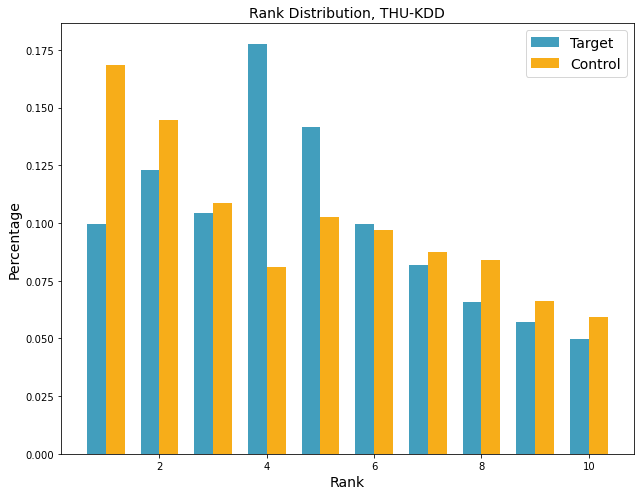

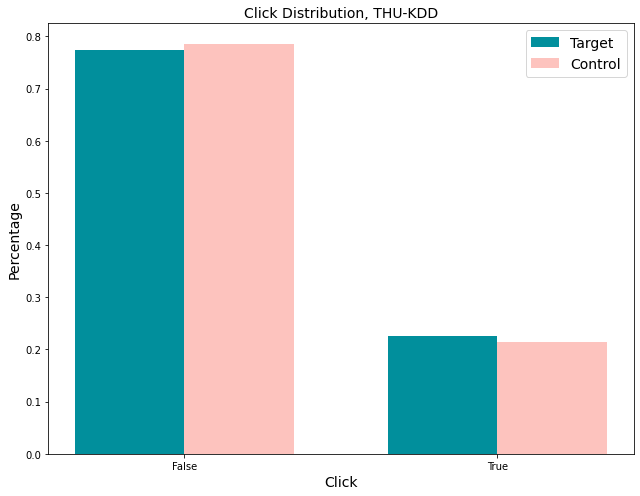

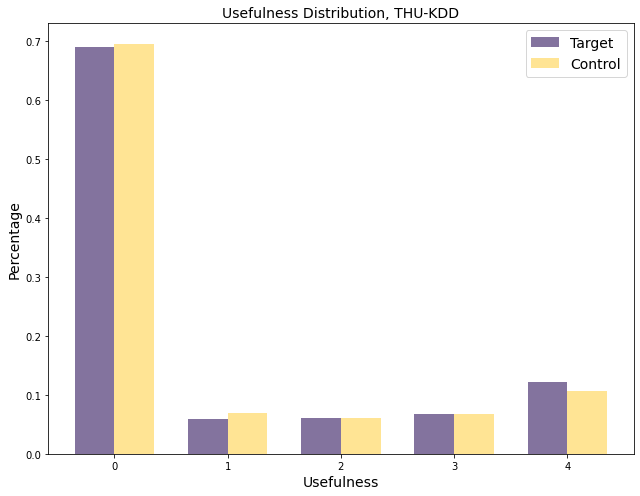

In [52]:
# Plot Rank Distribution and save as PDF
plot_and_save_chart(ranks, target_ranks_percentage, control_ranks_percentage, 
                    'Rank Distribution, THU-KDD', 'Rank', 'Percentage', 'kdd_rank','#429EBD', '#F7AD19',(9,7))

# Plot Click Distribution and save as PDF
plot_and_save_chart(click_labels, target_clicks_percentage, control_clicks_percentage, 
                    'Click Distribution, THU-KDD', 'Click', 'Percentage', 'kdd_click_prob','#018F9C','#FDC3BE',(9,7))

# Plot Usefulness Distribution and save as PDF
plot_and_save_chart(usefulness_values, target_usefulness_percentage, control_usefulness_percentage, 
                    'Usefulness Distribution, THU-KDD', 'Usefulness', 'Percentage', 'kdd_usefulness', '#83739E', '#FFE494',(9,7))

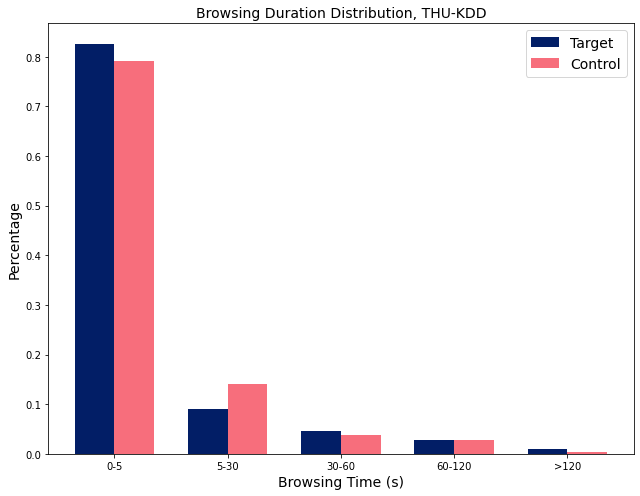

In [54]:
import matplotlib.pyplot as plt

# Extract rank, click, usefulness, and last_time values
def extract_values(data):
    ranks = [item['rank'] for item in data]
    clicks = [item['click'] for item in data]
    usefulness = [item['usefulness'] for item in data]
    last_times = [item['last_time'] for item in data]
    return ranks, clicks, usefulness, last_times

# Function to group last_time into categories
def group_last_time(last_times):
    grouped_last_times = []
    for time in last_times:
        if time <= 5:
            grouped_last_times.append('0-5')
        elif time <= 30:
            grouped_last_times.append('5-30')
        elif time <= 60:
            grouped_last_times.append('30-60')
        elif time <= 120:
            grouped_last_times.append('60-120')
        else:
            grouped_last_times.append('>120')
    return grouped_last_times

# Adjust the percentage calculation to account for ordering
def calculate_percentage_ordered(values, unique_values):
    total_len = len(values)
    return [values.count(val) / total_len for val in unique_values]

# Extract and group last_time values
target_ranks, target_clicks, target_usefulness, target_last_times = extract_values(target_doc_interaction)
control_ranks, control_clicks, control_usefulness, control_last_times = extract_values(control_doc_interaction)

target_grouped_last_times = group_last_time(target_last_times)
control_grouped_last_times = group_last_time(control_last_times)

# Get unique values for ordering
last_time_labels = ['0-5', '5-30', '30-60', '60-120', '>120']

# Calculate ordered percentages
target_last_times_percentage = calculate_percentage_ordered(target_grouped_last_times, last_time_labels)
control_last_times_percentage = calculate_percentage_ordered(control_grouped_last_times, last_time_labels)

# Plot and save chart
plot_and_save_chart(last_time_labels, target_last_times_percentage, control_last_times_percentage,
                    'Browsing Duration Distribution, THU-KDD', 'Browsing Time (s)', 'Percentage',
                    'kdd_time', '#021E66', '#F76E7C',(9,7))

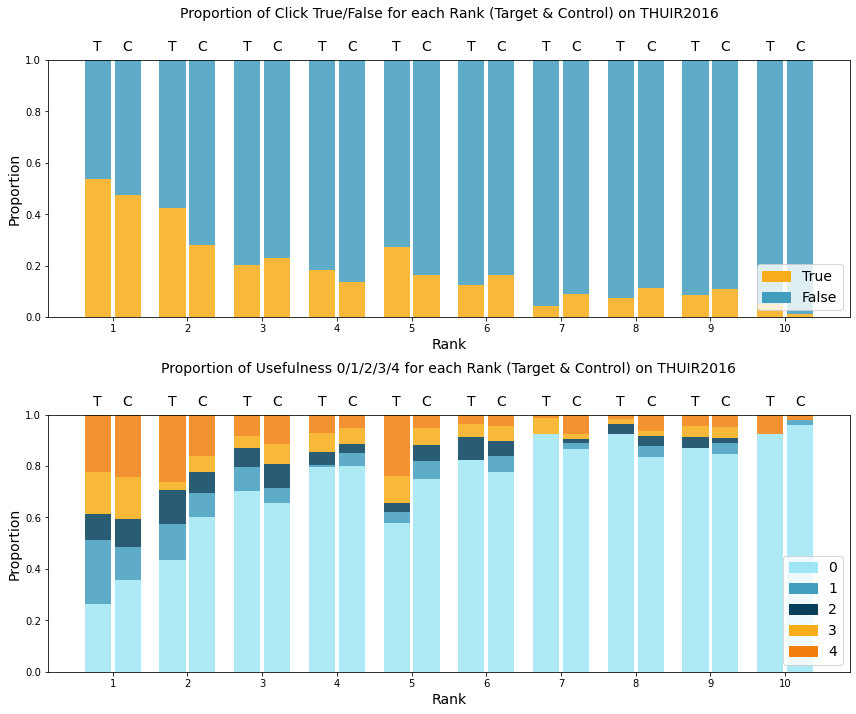

In [38]:
import os
# Color mapping for click values
click_color_mapping = {'True': '#F7AD19', 'False': '#429EBD'}
usefulness_color_mapping = {0: '#9FE7F5', 1: '#429EBD', 2: '#053F5C', 3: '#F7AD19', 4: '#F27F0C'}

# To store the proportions of click True/False for each rank for control group
control_click_proportions = {}

# To store the proportions of usefulness 0/1/2/3/4 for each rank for control group
control_usefulness_proportions = {}

# Function to calculate the proportions for click and usefulness for given data
def calculate_proportions(data, click_proportions, usefulness_proportions):
    for entry in data:
        rank = entry['rank'] + 1
        click = entry['click']
        usefulness = entry['usefulness']

        # Initialize the dictionaries if the rank is encountered for the first time
        if rank not in click_proportions:
            click_proportions[rank] = {'True': 0, 'False': 0}
        if rank not in usefulness_proportions:
            usefulness_proportions[rank] = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

        # Increment the count of click True/False and usefulness 0/1/2/3/4 for the respective rank
        click_proportions[rank][str(click)] += 1
        usefulness_proportions[rank][usefulness] += 1

    # Calculate the proportions
    for rank in click_proportions:
        total = sum(click_proportions[rank].values())
        click_proportions[rank] = {k: v / total for k, v in click_proportions[rank].items()}

    for rank in usefulness_proportions:
        total = sum(usefulness_proportions[rank].values())
        usefulness_proportions[rank] = {k: v / total for k, v in usefulness_proportions[rank].items()}

    return click_proportions, usefulness_proportions

# Calculating proportions for target and control data
click_proportions, usefulness_proportions = calculate_proportions(target_doc_interaction, {}, {})
control_click_proportions, control_usefulness_proportions = calculate_proportions(control_doc_interaction, {}, {})

# Function to plot histograms with separate bars for target and control for each rank
def plot_histogram(ax, target_proportions, control_proportions, title, ylabel, unique_values, color_mapping):
    all_ranks = sorted(set(target_proportions.keys()).union(control_proportions.keys()))
    bar_width = 0.35  # the width of the bars
    gap_width = 0.05  # the gap between bars of target and control
    
    for rank in all_ranks:
        target_values = target_proportions.get(rank, {})
        control_values = control_proportions.get(rank, {})
        
        # Position of the bars
        target_position = rank - (bar_width + gap_width) / 2
        control_position = rank + (bar_width + gap_width) / 2
        
        # Plotting bars for target
        bottom = 0
        for value in unique_values:
            proportion = target_values.get(value, 0)
            ax.bar(target_position, proportion, width=bar_width, color=color_mapping[value], bottom=bottom, alpha=0.85)
            bottom += proportion
        
        # Plotting bars for control
        bottom = 0
        for value in unique_values:
            proportion = control_values.get(value, 0)
            ax.bar(control_position, proportion, width=bar_width, color=color_mapping[value], bottom=bottom, alpha=0.85)
            bottom += proportion
    
    ax.set_xlabel('Rank', fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, y=1.14, fontsize=14)
    ax.set_xticks(all_ranks)
    
    # Adding text to indicate which bar is target and which is control
    for rank in all_ranks:
        ax.text(rank - (bar_width + gap_width) / 2, 1.05, 'T', ha='center', va='center', fontsize=14, transform=ax.get_xaxis_transform())
        ax.text(rank + (bar_width + gap_width) / 2, 1.05, 'C', ha='center', va='center', fontsize=14, transform=ax.get_xaxis_transform())
    
    # Simplified legend
    legend_labels = {v: k for k, v in color_mapping.items()}
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in color_mapping.values()]
    ax.legend(handles, [legend_labels[color] for color in color_mapping.values()], loc='lower right', fontsize=14,)


# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Plotting the histogram for Click Proportions
plot_histogram(axs[0], click_proportions, control_click_proportions, 'Proportion of Click True/False for each Rank (Target & Control) on THUIR2016', 'Proportion', ['True', 'False'], click_color_mapping)

# Plotting the histogram for Usefulness Proportions
plot_histogram(axs[1], usefulness_proportions, control_usefulness_proportions, 'Proportion of Usefulness 0/1/2/3/4 for each Rank (Target & Control) on THUIR2016', 'Proportion', [0, 1, 2, 3, 4], usefulness_color_mapping)

plt.tight_layout()


# Function to save the histograms to files
def save_histogram(target_proportions, control_proportions, title, ylabel, unique_values, color_mapping, filename):
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_histogram(ax, target_proportions, control_proportions, title, ylabel, unique_values, color_mapping)
    plt.tight_layout()
    #plt.show()
    plt.savefig(filename)
    plt.close(fig)

# Saving the histogram for Click Proportions
click_plot_filepath = save_histogram(click_proportions, control_click_proportions, 'Click probability for each rank on THU-KDD', 'Proportion', ['True', 'False'], click_color_mapping, './output/fig/kdd_click_proportions_plot.pdf')

# Saving the histogram for Usefulness Proportions
usefulness_plot_filepath = save_histogram(usefulness_proportions, control_usefulness_proportions, 'Usefulness for each rank on THU-KDD', 'Proportion', [0, 1, 2, 3, 4], usefulness_color_mapping, './output/fig/kdd_usefulness_proportions_plot.pdf')




In [39]:
# Define the bins for mapping the last_time to discrete intervals
bins = [0, 5, 30, 60, 120, float('inf')]
labels = ['0-5', '5-30', '30-60', '60-120', '>120']

# Function to map the last_time to discrete intervals
def map_last_time_to_interval(data):
    last_time_intervals = {}
    for entry in data:
        rank = entry['rank']
        last_time = entry['last_time']
        
        # Find the corresponding interval for the last_time
        for i, b in enumerate(bins):
            if last_time <= b:
                interval = labels[i] if i == 0 else labels[i - 1]
                break
        
        # Update the last_time_intervals dictionary
        if rank not in last_time_intervals:
            last_time_intervals[rank] = {label: 0 for label in labels}
        last_time_intervals[rank][interval] += 1
        
    # Calculate proportions for each rank
    for rank, intervals in last_time_intervals.items():
        total = sum(intervals.values())
        last_time_intervals[rank] = {interval: count / total for interval, count in intervals.items()}
    
    return last_time_intervals

# Map the last_time to discrete intervals for target and control groups
target_last_time_intervals = map_last_time_to_interval(target_doc_interaction)
control_last_time_intervals = map_last_time_to_interval(control_doc_interaction)
#print(control_last_time_intervals)
# Color mapping for last_time values
last_time_color_mapping = {'0-5': '#83739E', '5-30': '#018F9C', '30-60': '#FE7B72', '60-120': '#FDC3BE',  '>120': '#FFE494'}

# Saving the histogram for Last Time Proportions
last_time_plot_filepath = save_histogram(target_last_time_intervals, control_last_time_intervals, 'Browsing time for each rank on THU-KDD', 'Proportion', labels, last_time_color_mapping, './output/fig/kdd_last_time_proportions_plot.pdf')

# Returning the file path of the saved plot
last_time_plot_filepath

In [40]:
from scipy import stats


# Calculate metrics for a given interaction list
def calculate_metrics(interaction_list):
    click_probs = [1 if interaction['click'] else 0 for interaction in interaction_list]
    avg_click_prob = sum(click_probs) / len(interaction_list)

    browsing_times = [interaction['last_time'] if interaction['click'] else 0 for interaction in interaction_list]
    avg_browsing_time = sum(browsing_times) / len(interaction_list)

    usefulness_scores = [interaction['usefulness'] for interaction in interaction_list]
    avg_usefulness = sum(usefulness_scores) / len(interaction_list)
    
    ranks = [entry['rank'] for entry in interaction_list]
    avg_rank = np.mean(ranks)
    
    hover_probs = [1 if interaction['hover'] else 0 for interaction in interaction_list]
    avg_hover_prob = sum(hover_probs) / len(interaction_list)

    hover_browsing_times = [interaction['hover_last_time'] if interaction['hover'] else 0 for interaction in interaction_list]
    avg_hover_browsing_time = sum(hover_browsing_times) / len(interaction_list)
    
    return avg_click_prob, avg_browsing_time, avg_usefulness, avg_rank, avg_hover_prob, avg_hover_browsing_time

# Calculate the metrics for both interaction lists
target_avg_click_prob, target_avg_browsing_time, target_avg_usefulness, target_avg_rank, target_avg_hover_prob, target_avg_hover_browsing_time = calculate_metrics(target_doc_interaction)
control_avg_click_prob, control_avg_browsing_time, control_avg_usefulness, control_avg_rank, control_avg_hover_prob, control_avg_hover_browsing_time, = calculate_metrics(control_doc_interaction)

# Conduct t-tests to compare the means
click_prob_t_stat, click_prob_p_val = stats.ttest_ind([interaction['click'] for interaction in target_doc_interaction],
                                                     [interaction['click'] for interaction in control_doc_interaction])

browsing_time_t_stat, browsing_time_p_val = stats.ttest_ind(
    [interaction['last_time'] if interaction['click'] else 0 for interaction in target_doc_interaction],
    [interaction['last_time'] if interaction['click'] else 0 for interaction in control_doc_interaction]
)

usefulness_t_stat, usefulness_p_val = stats.ttest_ind([interaction['usefulness'] for interaction in target_doc_interaction],
                                                     [interaction['usefulness'] for interaction in control_doc_interaction])


rank_t_stat, rank_p_val = stats.ttest_ind([interaction['rank'] for interaction in target_doc_interaction],
                                                     [interaction['rank'] for interaction in control_doc_interaction])

hover_prob_t_stat, hover_prob_p_val = stats.ttest_ind([interaction['hover'] for interaction in target_doc_interaction],
                                                     [interaction['hover'] for interaction in control_doc_interaction])

hover_browsing_time_t_stat, hover_browsing_time_p_val = stats.ttest_ind(
    [interaction['hover_last_time'] if interaction['hover'] else 0 for interaction in target_doc_interaction],
    [interaction['hover_last_time'] if interaction['hover'] else 0 for interaction in control_doc_interaction]
)


{
    "target_metrics": {
        "avg_click_prob": target_avg_click_prob,
        "avg_browsing_time": target_avg_browsing_time,
        "avg_hover_prob": target_avg_hover_prob,
        "avg_hover_time": target_avg_hover_browsing_time,
        "avg_usefulness": target_avg_usefulness,
        "avg_rank": target_avg_rank,
    },
    "control_metrics": {
        "avg_click_prob": control_avg_click_prob,
        "avg_browsing_time": control_avg_browsing_time,
        "avg_hover_prob": control_avg_hover_prob,
        "avg_hover_time": control_avg_hover_browsing_time,
        "avg_usefulness": control_avg_usefulness,
        "avg_rank": control_avg_rank,
    },
    "t_test_results": {
        "click_prob": {"t_stat": click_prob_t_stat, "p_val": click_prob_p_val},
        "browsing_time": {"t_stat": browsing_time_t_stat, "p_val": browsing_time_p_val},
        "hover_prob": {"t_stat": hover_prob_t_stat, "p_val": hover_prob_p_val},
        "hover_time": {"t_stat": hover_browsing_time_t_stat, "p_val": hover_browsing_time_p_val},
        "usefulness": {"t_stat": usefulness_t_stat, "p_val": usefulness_p_val},
        "rank": {"t_stat": rank_t_stat, "p_val": rank_p_val},
    }
}

{'target_metrics': {'avg_click_prob': 0.22608695652173913,
  'avg_browsing_time': 8.259952795031062,
  'avg_hover_prob': 0.4782608695652174,
  'avg_hover_time': 0.7113900621118006,
  'avg_usefulness': 0.8695652173913043,
  'avg_rank': 3.7850931677018633},
 'control_metrics': {'avg_click_prob': 0.2143439282803586,
  'avg_browsing_time': 7.045639771801141,
  'avg_hover_prob': 0.4820700896495517,
  'avg_hover_time': 586.8761206193969,
  'avg_usefulness': 0.8227383863080685,
  'avg_rank': 3.6813365933170332},
 't_test_results': {'click_prob': {'t_stat': 0.7009468696585482,
   'p_val': 0.4833862460290279},
  'browsing_time': {'t_stat': 0.8964173451173981, 'p_val': 0.3700961562909867},
  'hover_prob': {'t_stat': -0.18764529469301877, 'p_val': 0.8511664055332725},
  'hover_time': {'t_stat': -1.981993920431539, 'p_val': 0.04756384774577251},
  'usefulness': {'t_stat': 0.8161441746073848, 'p_val': 0.4144773654166751},
  'rank': {'t_stat': 0.9183577084788948, 'p_val': 0.35849962581786454}}}

In [41]:
# Split the interactions into three groups based on rank
def split_by_rank(interactions):
    group1 = [item for item in interactions if 0 <= item['rank'] <= 4]
    group2 = [item for item in interactions if 5 <= item['rank'] <= 9]
    return group1, group2

# Split target and control interactions by rank
target_groups = split_by_rank(target_doc_interaction)
control_groups = split_by_rank(control_doc_interaction)

# Calculate metrics for each group and perform t-tests
results = []

for i in range(2):
    target_metrics = calculate_metrics(target_groups[i])
    control_metrics = calculate_metrics(control_groups[i])

    click_prob_ttest = stats.ttest_ind([entry['click'] for entry in target_groups[i]], [entry['click'] for entry in control_groups[i]])
    rank_ttest = stats.ttest_ind([entry['rank'] for entry in target_groups[i]], [entry['rank'] for entry in control_groups[i]])
    view_time_ttest = stats.ttest_ind([entry['last_time'] if entry['click'] else 0 for entry in target_groups[i]], 
                                [entry['last_time'] if entry['click'] else 0 for entry in control_groups[i]])
    usefulness_ttest = stats.ttest_ind([entry['usefulness'] for entry in target_groups[i]], [entry['usefulness'] for entry in control_groups[i]])

    results.append({
        'group': i+1,
        'target_metrics': target_metrics,
        'control_metrics': control_metrics,
        'click_prob_ttest': click_prob_ttest,
        'view_time_ttest': view_time_ttest,
        'usefulness_ttest': usefulness_ttest,
        'rank_ttest': rank_ttest,
    })

results

[{'group': 1,
  'target_metrics': (0.3057692307692308,
   11.146778846153849,
   1.1634615384615385,
   2.2153846153846155,
   0.5942307692307692,
   1.0135019230769229),
  'control_metrics': (0.2860026917900404,
   9.46164199192463,
   1.0995962314939434,
   1.6783310901749664,
   0.6292059219380888,
   903.4441453566621),
  'click_prob_ttest': Ttest_indResult(statistic=0.8537157743046433, pvalue=0.3933645237924853),
  'view_time_ttest': Ttest_indResult(statistic=0.8150469051897451, pvalue=0.4151423116612719),
  'usefulness_ttest': Ttest_indResult(statistic=0.8148205288542476, pvalue=0.41527186770648417),
  'rank_ttest': Ttest_indResult(statistic=7.410777706654219, pvalue=1.841465866767866e-13)},
 {'group': 2,
  'target_metrics': (0.08070175438596491,
   2.9927614035087715,
   0.3333333333333333,
   6.649122807017544,
   0.26666666666666666,
   0.16016842105263163),
  'control_metrics': (0.10433884297520661,
   3.3367768595041323,
   0.3977272727272727,
   6.756198347107438,
   0.2561

## Chi-square test

In [42]:
from scipy import stats
from scipy.stats import chi2_contingency
import collections

target_rank = [entry['rank'] for entry in target_doc_interaction]
control_rank = [entry['rank'] for entry in control_doc_interaction]

# Count the frequency of each rank in both target and control groups
target_rank_count = collections.Counter(target_rank)
control_rank_count = collections.Counter(control_rank)

# Create a list of all unique ranks
all_ranks = list(set(target_rank + control_rank))

# Create frequency lists for target and control, ensuring each rank is represented
target_freq = [target_rank_count.get(rank, 0) for rank in all_ranks]
control_freq = [control_rank_count.get(rank, 0) for rank in all_ranks]

# Perform Chi-Square Test
chi2, p_value, _, _ = chi2_contingency([target_freq, control_freq])

chi2, p_value

(87.80343756684766, 4.487087064072883e-15)

# logistic regression

## merge data

In [43]:
import pandas as pd
from sklearn.linear_model import LogisticRegression


#Add 'has_decoy' attribute and merge the two lists
for entry in control_doc_interaction:
    entry['has_decoy'] = 0

for entry in target_doc_interaction:
    entry['has_decoy'] = 1

merged_data = control_doc_interaction + target_doc_interaction

# Convert the merged data to a DataFrame for easier manipulation
df = pd.DataFrame(merged_data)

# Create dummy variables for categorical variables
dummy_fields = ['rank', 'task_id', 'student_id', #'relevance'
               ]
for field in dummy_fields:
    dummies = pd.get_dummies(df[field], prefix=field, drop_first=True)
    df = pd.concat([df, dummies], axis=1)

# Drop original categorical fields and other non-predictor fields
fields_to_drop = ['docno', 'rank', 'last_time', 'usefulness', 'student_id', 'task_id', 'query_id', 'hover_last_time', 'relevance']
df = df.drop(fields_to_drop, axis=1)



In [44]:
df.columns.tolist()

['click',
 'hover',
 'has_decoy',
 'rank_1',
 'rank_2',
 'rank_3',
 'rank_4',
 'rank_5',
 'rank_6',
 'rank_7',
 'rank_8',
 'rank_9',
 'task_id_10',
 'task_id_11',
 'task_id_12',
 'task_id_2',
 'task_id_3',
 'task_id_4',
 'task_id_7',
 'task_id_8',
 'student_id_2012012180',
 'student_id_2013012187',
 'student_id_2013311064',
 'student_id_2014010632',
 'student_id_2014011501',
 'student_id_2014012437',
 'student_id_2014012759',
 'student_id_2014310881',
 'student_id_2015010242',
 'student_id_2015011730',
 'student_id_2015011907',
 'student_id_2015011938',
 'student_id_2015012322',
 'student_id_2015012923',
 'student_id_2015030002',
 'student_id_2015211220',
 'student_id_2016011317',
 'student_id_2016011351',
 'student_id_2016011417',
 'student_id_2016011495',
 'student_id_2016012270',
 'student_id_2016012299',
 'student_id_2016050025',
 'student_id_2016050040',
 'student_id_2016210825',
 'student_id_2016211383',
 'student_id_2016211684',
 'student_id_2016212450',
 'student_id_2016310023'

In [45]:
from sklearn.linear_model import LogisticRegression

# Features (X) and Labels (y) for 'click'
X_click = df.drop(['click', 'hover'], axis=1)
y_click = df['click']

# Features (X) and Labels (y) for 'hover'
X_hover = df.drop(['click', 'hover'], axis=1)
y_hover = df['hover']

In [46]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    # https://stackoverflow.com/a/39813304/1956309
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# min_variance = .9 * (1 - .9)  # You can play here with different values.
min_variance = 0.1
low_variance = variance_threshold_selector(df, min_variance) 
print('columns removed:')
df.columns ^ low_variance.columns
df.shape
df.shape
X = low_variance

columns removed:


/var/folders/7k/8q9xq4596mb6rkfh3c6gknc00000gn/T/ipykernel_60928/3194216113.py:13: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  df.columns ^ low_variance.columns


In [47]:
import statsmodels.api as sm

# Add constant for intercept term
X_click_const = sm.add_constant(X_click)
X_hover_const = sm.add_constant(X_hover)

# Logistic regression for 'click'
logit_model_click = sm.Logit(y_click, X_click_const)
result_click = logit_model_click.fit(disp=0)

# Logistic regression for 'hover'
logit_model_hover = sm.Logit(y_hover, X_hover_const)
result_hover = logit_model_hover.fit(disp=0)

# Summary tables, which include p-values
summary_click = result_click.summary()
summary_hover = result_hover.summary()

summary_click, summary_hover

(<class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:                  click   No. Observations:                 3259
 Model:                          Logit   Df Residuals:                     3191
 Method:                           MLE   Df Model:                           67
 Date:                Wed, 11 Oct 2023   Pseudo R-squ.:                  0.1349
 Time:                        21:24:02   Log-Likelihood:                -1475.7
 converged:                       True   LL-Null:                       -1705.8
 Covariance Type:            nonrobust   LLR p-value:                 5.507e-60
                             coef    std err          z      P>|z|      [0.025      0.975]
 -----------------------------------------------------------------------------------------
 const                     0.6560      0.395      1.660      0.097      -0.118       1.430
 has_decoy                 0.2191    

In [48]:
# Convert the merged data to a DataFrame for easier manipulation
merged_df = pd.DataFrame(merged_data)

# Create dummy variables for categorical variables
dummy_fields_ols = ['rank', 'task_id', 'student_id', #'relevance'
                   ]
for field in dummy_fields_ols:
    dummies = pd.get_dummies(merged_df[field], prefix=field, drop_first=True)
    merged_df = pd.concat([merged_df, dummies], axis=1)

# Drop original categorical fields
fields_to_drop_ols = ['docno', 'click', 'hover', 'query_id', 'student_id', 'task_id', 'relevance', 'rank']
df_ols = merged_df.drop(fields_to_drop_ols, axis=1)

# Show the first few rows to confirm the changes
df_ols.head()

,last_time,usefulness,hover_last_time,has_decoy,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,...,student_id_2018000001,student_id_2018000002,student_id_2018000003,student_id_2018000004,student_id_2018000005,student_id_2018000006,student_id_2018000007,student_id_2018000008,student_id_2018000009,student_id_2018000010
0,53.0,4,14008.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,48.0,0,56417.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0,0.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
import statsmodels.api as sm

# Features (X) and Labels (y) for 'last_time'
X_last_time = df_ols.drop(['last_time', 'hover_last_time', 'usefulness'], axis=1)
y_last_time = df_ols['last_time']

# Add constant for intercept term
X_last_time_const = sm.add_constant(X_last_time)

# OLS regression for 'last_time'
ols_model_last_time = sm.OLS(y_last_time, X_last_time_const)
result_last_time = ols_model_last_time.fit()

# Summary table, which includes p-values
summary_last_time = result_last_time.summary()
summary_last_time

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              last_time   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     3.161
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           3.18e-16
Time:                        21:24:02   Log-Likelihood:                -15949.
No. Observations:                3259   AIC:                         3.203e+04
Df Residuals:                    3191   BIC:                         3.245e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    14.7473      5.302      2.781      0.005       4.351      25.143
has_decoy                 1.8196      1.364      1.334      0.182      -0.855       4.494
rank_1                   -4.8067      2.133     -2.253      0.024      -8.990      -0.624
rank_2                   -7.6422      2.300     -3.323      0.001     -12.152      -3.133
rank_3                   -3.4241      2.337     -1.465      0.143      -8.006       1.158
rank_4                   -7.8832      2.276     -3.464      0.001     -12.345      -3.421
rank_5                   -9.3781      2.366     -3.963      0.000     -14.018      -4.738
rank_6                  -11.4111      2.459     -4.641      0.000     -16.232      -6.590
rank_7                  -10.5543      2.523     -4.183      0.000     -15.502      -5.607
rank_8                   -9.7993      2.712     -3.613      0.000     -15.117      -4.482
rank_9                  -13.5720      2.833     -4.791      0.000     -19.127      -8.017
task_id_10               -2.4494      3.050     -0.803      0.422      -8.430       3.531
task_id_11               -1.1085      3.099     -0.358      0.721      -7.184       4.967
task_id_12               -3.4613      3.121     -1.109      0.267      -9.580       2.657
task_id_2                -2.8099      3.083     -0.911      0.362      -8.856       3.236
task_id_3                 4.1778      2.964      1.409      0.159      -1.634       9.990
task_id_4                 0.9374      3.073      0.305      0.760      -5.087       6.962
task_id_7                -1.6714      3.045     -0.549      0.583      -7.642       4.300
task_id_8                -2.1047      3.128     -0.673      0.501      -8.237       4.028
student_id_2012012180    -4.0160      7.494     -0.536      0.592     -18.709      10.677
student_id_2013012187     7.0756      6.200      1.141      0.254      -5.082      19.233
student_id_2013311064    -0.1384     10.174     -0.014      0.989     -20.087      19.810
student_id_2014010632    -1.7282      7.865     -0.220      0.826     -17.149      13.692
student_id_2014011501    -2.1268      5.474     -0.389      0.698     -12.860       8.606
student_id_2014012437     8.3195      6.006      1.385      0.166      -3.457      20.096
student_id_2014012759     7.4988      7.792      0.962      0.336      -7.779      22.776
student_id_2014310881     0.2759      6.320      0.044      0.965     -12.115      12.667
student_id_2015010242    -3.2517      6.879     -0.473      0.636     -16.739      10.235
student_id_2015011730    -2.4452      5.589     -0.438      0.662     -13.404       8.513
student_id_2015011907    -0.5972      6.169     -0.097      0.923     -12.692      11.498
student_id_2015011938     7.6128      5.970      1.275      0.202      -4.092      19.317
student_id_2015012322  

In [50]:
# Features (X) and Labels (y) for 'usefulness'
X_usefulness = df_ols.drop(['last_time', 'hover_last_time','usefulness'], axis=1)
y_usefulness = df_ols['usefulness']

# Add constant for intercept term
X_usefulness_const = sm.add_constant(X_usefulness)

# OLS regression for 'usefulness'
ols_model_usefulness = sm.OLS(y_usefulness, X_usefulness_const)
result_usefulness = ols_model_usefulness.fit()

# Summary table, which includes p-values
summary_usefulness = result_usefulness.summary()
summary_usefulness

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             usefulness   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     10.06
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           5.18e-90
Time:                        21:24:02   Log-Likelihood:                -5437.3
No. Observations:                3259   AIC:                         1.101e+04
Df Residuals:                    3191   BIC:                         1.142e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.3423      0.211     11.115      0.000       1.929       2.755
has_decoy                 0.1485      0.054      2.740      0.006       0.042       0.255
rank_1                   -0.6112      0.085     -7.209      0.000      -0.777      -0.445
rank_2                   -0.9191      0.091    -10.055      0.000      -1.098      -0.740
rank_3                   -1.2857      0.093    -13.843      0.000      -1.468      -1.104
rank_4                   -0.9980      0.090    -11.035      0.000      -1.175      -0.821
rank_5                   -1.3267      0.094    -14.107      0.000      -1.511      -1.142
rank_6                   -1.4573      0.098    -14.914      0.000      -1.649      -1.266
rank_7                   -1.4133      0.100    -14.093      0.000      -1.610      -1.217
rank_8                   -1.4116      0.108    -13.097      0.000      -1.623      -1.200
rank_9                   -1.6453      0.113    -14.613      0.000      -1.866      -1.425
task_id_10               -0.3540      0.121     -2.920      0.004      -0.592      -0.116
task_id_11               -0.1867      0.123     -1.516      0.130      -0.428       0.055
task_id_12               -0.3117      0.124     -2.513      0.012      -0.555      -0.068
task_id_2                -0.2699      0.123     -2.203      0.028      -0.510      -0.030
task_id_3                -0.4090      0.118     -3.472      0.001      -0.640      -0.178
task_id_4                -0.0585      0.122     -0.479      0.632      -0.298       0.181
task_id_7                -0.3892      0.121     -3.216      0.001      -0.627      -0.152
task_id_8                -0.1343      0.124     -1.080      0.280      -0.378       0.109
student_id_2012012180    -0.6059      0.298     -2.034      0.042      -1.190      -0.022
student_id_2013012187    -0.1549      0.246     -0.629      0.530      -0.638       0.328
student_id_2013311064     0.1396      0.404      0.345      0.730      -0.653       0.932
student_id_2014010632    -0.4687      0.313     -1.499      0.134      -1.082       0.144
student_id_2014011501    -0.4118      0.218     -1.893      0.058      -0.838       0.015
student_id_2014012437    -0.2116      0.239     -0.887      0.375      -0.680       0.256
student_id_2014012759    -0.7435      0.310     -2.401      0.016      -1.351      -0.136
student_id_2014310881    -0.4382      0.251     -1.745      0.081      -0.931       0.054
student_id_2015010242    -0.6669      0.273     -2.439      0.015      -1.203      -0.131
student_id_2015011730    -0.3165      0.222     -1.425      0.154      -0.752       0.119
student_id_2015011907    -0.1427      0.245     -0.582      0.561      -0.623       0.338
student_id_2015011938    -0.6487      0.237     -2.734      0.006      -1.114      -0.184
student_id_2015012322  

In [51]:
# Features (X) and Labels (y) for 'hover'
X_hover = df_ols.drop(['last_time', 'hover_last_time','usefulness'], axis=1)
y_hover = df_ols['hover_last_time']

# Add constant for intercept term
X_hover_const = sm.add_constant(X_hover)

# OLS regression for 'usefulness'
ols_model_hover = sm.OLS(y_hover, X_hover_const)
result_hover = ols_model_hover.fit()

# Summary table, which includes p-values
summary_hover = result_hover.summary()
summary_hover

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        hover_last_time   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.982
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           1.54e-14
Time:                        21:24:02   Log-Likelihood:                -33509.
No. Observations:                3259   AIC:                         6.715e+04
Df Residuals:                    3191   BIC:                         6.757e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   757.5661   1160.202      0.653      0.514   -1517.251    3032.383
has_decoy              -379.4703    298.448     -1.271      0.204    -964.640     205.700
rank_1                -1163.5897    466.818     -2.493      0.013   -2078.883    -248.297
rank_2                 -463.1652    503.245     -0.920      0.357   -1449.881     523.551
rank_3                -1375.3882    511.370     -2.690      0.007   -2378.035    -372.741
rank_4                -1172.5035    497.934     -2.355      0.019   -2148.807    -196.200
rank_5                -1351.4382    517.795     -2.610      0.009   -2366.684    -336.193
rank_6                -1279.6435    538.015     -2.378      0.017   -2334.534    -224.753
rank_7                -1278.7494    552.123     -2.316      0.021   -2361.300    -196.198
rank_8                -1370.9786    593.437     -2.310      0.021   -2534.536    -207.422
rank_9                -1471.6945    619.901     -2.374      0.018   -2687.140    -256.249
task_id_10             1047.1985    667.433      1.569      0.117    -261.442    2355.839
task_id_11              248.9538    678.017      0.367      0.714   -1080.439    1578.346
task_id_12              193.5874    682.834      0.284      0.777   -1145.250    1532.425
task_id_2               612.9348    674.700      0.908      0.364    -709.956    1935.825
task_id_3               156.4267    648.578      0.241      0.809   -1115.245    1428.098
task_id_4               144.7150    672.307      0.215      0.830   -1173.483    1462.913
task_id_7               593.3914    666.357      0.891      0.373    -713.139    1899.922
task_id_8              -164.2672    684.408     -0.240      0.810   -1506.191    1177.656
student_id_2012012180   370.6221   1639.727      0.226      0.821   -2844.404    3585.648
student_id_2013012187   103.9118   1356.736      0.077      0.939   -2556.252    2764.075
student_id_2013311064   166.3926   2226.211      0.075      0.940   -4198.556    4531.341
student_id_2014010632   249.8390   1720.927      0.145      0.885   -3124.397    3624.075
student_id_2014011501    44.0546   1197.804      0.037      0.971   -2304.489    2392.598
student_id_2014012437   288.0521   1314.198      0.219      0.827   -2288.706    2864.810
student_id_2014012759  3280.8794   1704.970      1.924      0.054     -62.068    6623.827
student_id_2014310881   -28.5726   1382.826     -0.021      0.984   -2739.891    2682.746
student_id_2015010242   177.9451   1505.148      0.118      0.906   -2773.210    3129.101
student_id_2015011730   147.0059   1222.946      0.120      0.904   -2250.833    2544.845
student_id_2015011907   147.9104   1349.755      0.110      0.913   -2498.565    2794.385
student_id_2015011938   243.4490   1306.203      0.186      0.852   -2317.634    2804.532
student_id_2015012322  